In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import AgglomerativeClustering as agg
import time
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold
np.random.seed(42)

## Load Data and Normalize

In [2]:
Genes = pd.read_csv("ClusterDataset.csv")
Genes = Genes[Genes["Name"]!="gene_variance"]



In [3]:
Subjects = pd.read_csv("SubjectsMeta.txt",sep='\t')

In [4]:
#get all genecolumns 
gene_cols = [g for g in Genes.columns if g.startswith("ENSG")]
#Remove gene column and features column convert to numpy array
gene_array = Genes.iloc[:,1:-1].to_numpy()
norm_genes = StandardScaler().fit_transform(gene_array)
data_genes = pd.DataFrame(norm_genes,columns=gene_cols)
data_genes["Name"]=Genes["Name"]
data_genes["tissue"]=Genes["tissue"]


In [5]:
data_genes["tissue"].nunique()

10

## Dimesionality Reduction


In [6]:
pca = PCA(n_components=3,random_state=42)
genes_PCA = pca.fit_transform(norm_genes)
plotPCA = pd.DataFrame(genes_PCA,columns=["Dim1","Dim2","Dim3"])
labels = data_genes["tissue"].to_list()#get labels for this and also agglomerative clustering
plotPCA["tissue"] = labels

In [7]:
fig = px.scatter(plotPCA,x="Dim1",y="Dim2",color="tissue",hover_data=["Dim1","Dim2","Dim3","tissue"],title="Tissue PCA from Gene Expression")
fig.update_traces(marker={"size":7,"opacity":0.5})
fig.show()

In [8]:
fig = px.scatter(plotPCA,x="Dim2",y="Dim3",color="tissue",hover_data=["Dim1","Dim2","Dim3","tissue"],title="Tissue PCA from Gene Expression")
fig.update_traces(marker={"size":7,"opacity":0.5})
fig.show()

In [9]:
fig = px.scatter(plotPCA,x="Dim1",y="Dim3",color="tissue",hover_data=["Dim1","Dim2","Dim3","tissue"],title="Tissue PCA from Gene Expression")
fig.update_traces(marker={"size":7,"opacity":0.5})
fig.show()

Interpretation:

Using dimensionality reduction to 3 dimensions shows excellent separation between Brain and Blood between Dim1 Vs. Dim2 and Dim2 Vs. Dim3 with less separation in Dim1 vs. Dim2. 

There is better across tissue separation between Dim1 and Dim3.

Colon and esophagus are unsurprisingly difficult to separate across all dims given they are both part of the GI track.

### Test Clustering performance at varying cluster dimensions

Using agglomerative clustering and linkage=Ward from first assignment

Already investigated different PCA clusters in first assignment and compared. Using first assginment code here.

In [10]:
#Using Ward

def Test_Agg(i,labels,norm_genes):
    '''
    Description: Take in PCA components, true labels, and numpy array of genes. 
    Compare various levels of dimensionality reduction using agglomerative clustering
    
    i, int: Components for PCA
    labels: list of true labels for ARI and NMI score
    norm_genes: numpy array of normalized genes

    return: dataframe with components, ari, nmi, and runtime
    
    '''
    pca = PCA(n_components=i,random_state=42)
    genes_PCA = pca.fit_transform(norm_genes)
    m = agg(n_clusters=10, linkage="ward")
    start = time.time()
    labels_m = m.fit_predict(genes_PCA)   
    stop = time.time()

    nmi = normalized_mutual_info_score(labels, labels_m)
    
    Run_time = stop-start

    return pd.DataFrame({"Components":i,"NMI":nmi,"Time":Run_time},index=[0])



#Test different componenst
c =[3,4,5,6,7,8,9,10,11,12,13,14,15,20,30,40,50,60,70]
Runs={}
results = Parallel(n_jobs=20)(delayed(Test_Agg)(i,labels,norm_genes) for i in c)
results = pd.concat(results, ignore_index=True)

In [ ]:
#results.to_csv("PCAreductionClustering.csv",index=False)
results = pd.read_csv("PCAreductionClustering.csv")

In [13]:
results.head(8)

,Components,NMI,Time
0,3,0.481994,11.585221
1,4,0.550187,12.301860
2,5,0.561811,14.560885
3,6,0.555532,13.414558
4,7,0.612304,12.803266
5,8,0.629417,13.176841
6,9,0.662923,14.347762
7,10,0.605466,14.759325


In [14]:
graphresults = results.melt(id_vars="Components",value_vars=["NMI","Time"],var_name="Metric",value_name="Value")

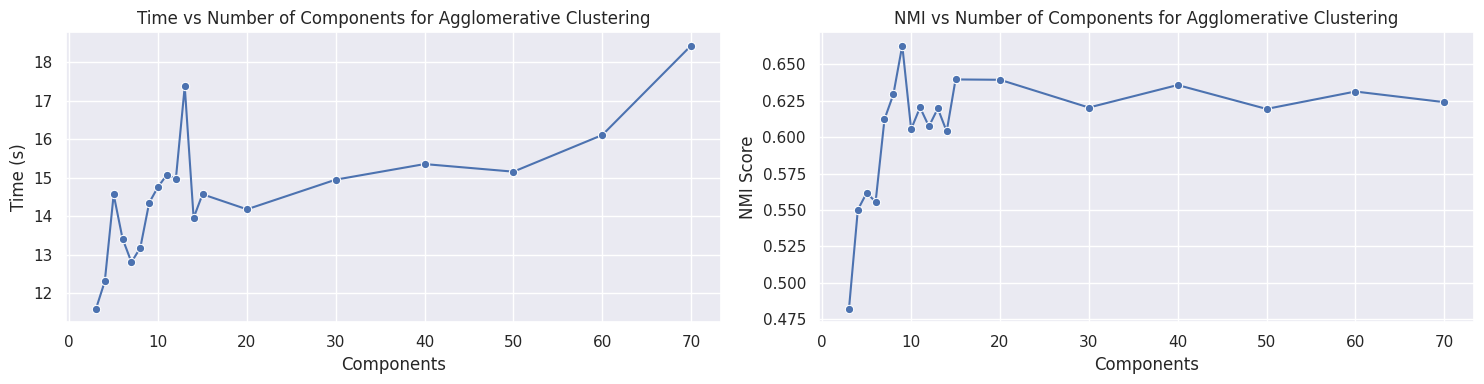

In [15]:
sns.set_theme()
fig, ax = plt.subplots(1, 2, figsize=(15, 4), sharex=True)
#Graph Time
sns.lineplot(data=graphresults[graphresults["Metric"] == "Time"],x="Components",y="Value",marker="o",ax=ax[0],)
ax[0].set_title("Time vs Number of Components for Agglomerative Clustering")
ax[0].set_ylabel("Time (s)")
#Graph Metrics
sns.lineplot(data=graphresults[graphresults["Metric"]=="NMI"],x="Components",y="Value",marker="o",ax=ax[1],)
ax[1].set_title("NMI vs Number of Components for Agglomerative Clustering")
ax[1].set_ylabel("NMI Score")
plt.tight_layout()
plt.show()


Interpretation:

As the number of components increases the time the algorithm takes to run increases unsurprisingly because there are more dimensions to calculate across. 

The number of PCA dimensions that lead to the highest NMI score (best clustering performance) with agglomerative clustering is 9 dimensions. Since agglomerative clustering is deterministic, the only way to run multiple experiments for error bars would be to change the random seed for the PCA clusters, which I do not do here. 

9 dimensions (NMI = 0.66) is a reasonably good score and makes sense given there are 10 labels and esophagus and colon have extremely similar expression data. 

## Ensemble-based Models to Predict Tissue

Compare RandomForestClassifier and AdaBoostClasssifer. Compare both to a baseline Dummy Classifier that predicts by class distribution.


In [20]:
#Create dataset for tissue classifier
TissueClassifier = data_genes.drop(columns="Name").dropna().copy()
X = TissueClassifier.iloc[:,:-1] #remove tissues col
y = TissueClassifier["tissue"]

#use stratify to preserve tissue distribition in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

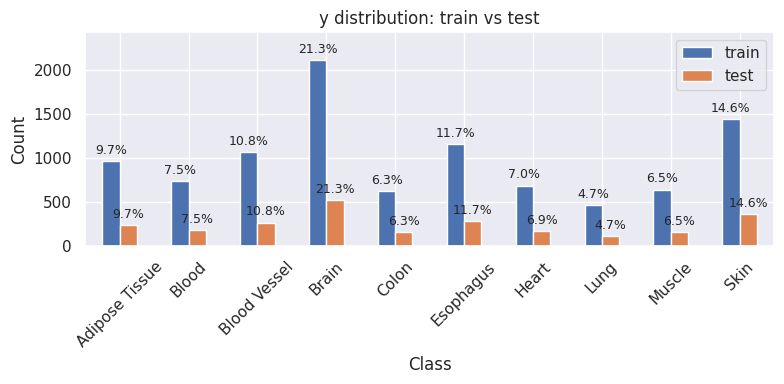

In [21]:
#chatGPT used to create this plot to assess class distributions between train and test

train_counts = y_train.value_counts().sort_index()
test_counts  = y_test.value_counts().sort_index()

counts = pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)
counts.columns = ["train", "test"]

fractions = counts.div(counts.sum(axis=0), axis=1)

ax = counts.plot(kind="bar", figsize=(8, 4))

totals = [counts["train"].sum(), counts["test"].sum()]
for i, container in enumerate(ax.containers):
    total = totals[i]
    labels = []
    for v in container.datavalues:
        labels.append(f"{(v / total):.1%}" if total else "0.0%")
    ax.bar_label(container, labels=labels, padding=3, fontsize=9)

ax.set_xlabel("Class")
ax.set_ylabel("Count")
ax.set_title("y distribution: train vs test")
plt.xticks(rotation=45)

top = counts.to_numpy().max()
ax.set_ylim(0, top * 1.15 if top else 1)

plt.tight_layout()
plt.show()


Class Distribution between train and test is evenly distributed

### Overfit a RFC by growing deep trees. 

Use grid search to compare params

What I expect:

No max depth will likely overfit and overfitting should increase as we go from tree depth of None (lots of trees) to 10 (fewer trees). 

Using all features (none) should overfit compared to sqrt of all features.


In [22]:

import os
print(os.cpu_count()) 


104


In [23]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#initialize random forest
rf = RandomForestClassifier(random_state=42,n_jobs=1) #make sure there is no nested parallelization (only want gridsearch to parallelize)
#Use grid search to find most over fit rf class
param_grid = {"n_estimators":[200,800],"max_depth":[None,10],"max_features":["sqrt"],"bootstrap":[True]}

gridSearch = GridSearchCV(estimator=rf,param_grid=param_grid,scoring="f1_macro",cv=cv,n_jobs=104,return_train_score=True,verbose=3)
gridSearch.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 4/5] END bootstrap=True, max_depth=10, max_features=sqrt, n_estimators=200;, score=(train=0.998, test=0.997) total time=  53.8s
[CV 2/5] END bootstrap=True, max_depth=10, max_features=sqrt, n_estimators=200;, score=(train=0.998, test=0.995) total time=  53.9s
[CV 1/5] END bootstrap=True, max_depth=10, max_features=sqrt, n_estimators=200;, score=(train=0.999, test=0.993) total time=  53.9s
[CV 3/5] END bootstrap=True, max_depth=10, max_features=sqrt, n_estimators=200;, score=(train=0.998, test=0.993) total time=  54.0s
[CV 5/5] END bootstrap=True, max_depth=10, max_features=sqrt, n_estimators=200;, score=(train=0.998, test=0.995) total time=  54.2s
[CV 1/5] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=200;, score=(train=1.000, test=0.993) total time= 1.0min
[CV 3/5] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=200;, score=(train=1.000, test=0.994) total time= 1.0min
[CV 2/5] END

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(n_jobs=1, random_state=42),
             n_jobs=104,
             param_grid={'bootstrap': [True], 'max_depth': [None, 10],
                         'max_features': ['sqrt'], 'n_estimators': [200, 800]},
             return_train_score=True, scoring='f1_macro', verbose=3)

In [36]:
#Created this plotting with chatGPT

def gridsearch_overfit_bar(gs, top_k=12):
    res = pd.DataFrame(gs.cv_results_).copy()

    needed = ["mean_train_score", "mean_test_score"]
    missing = [c for c in needed if c not in res.columns]

    param_cols = [c for c in res.columns if c.startswith("param_")]
    keep = ["mean_train_score", "mean_test_score"] + param_cols
    res = res[keep].copy()

    res["gap"] = res["mean_train_score"] - res["mean_test_score"]

    top_overfit = res.sort_values("gap", ascending=False).head(top_k).copy()

    def _col_or_blank(col):
        return top_overfit[col].astype(str) if col in top_overfit.columns else ""

    top_overfit["setting"] = (
        "trees=" + _col_or_blank("param_n_estimators")
        + " depth=" + _col_or_blank("param_max_depth")
        + " feat=" + _col_or_blank("param_max_features")
    )

    sns.set_theme()
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(data=top_overfit, x="gap", y="setting")
    ax.set_title(f"Top {top_k} most overfit settings")
    ax.set_xlabel("gap = mean_train_score minus mean_test_score")
    ax.set_ylabel("")
    plt.tight_layout()
    plt.show()

    return top_overfit


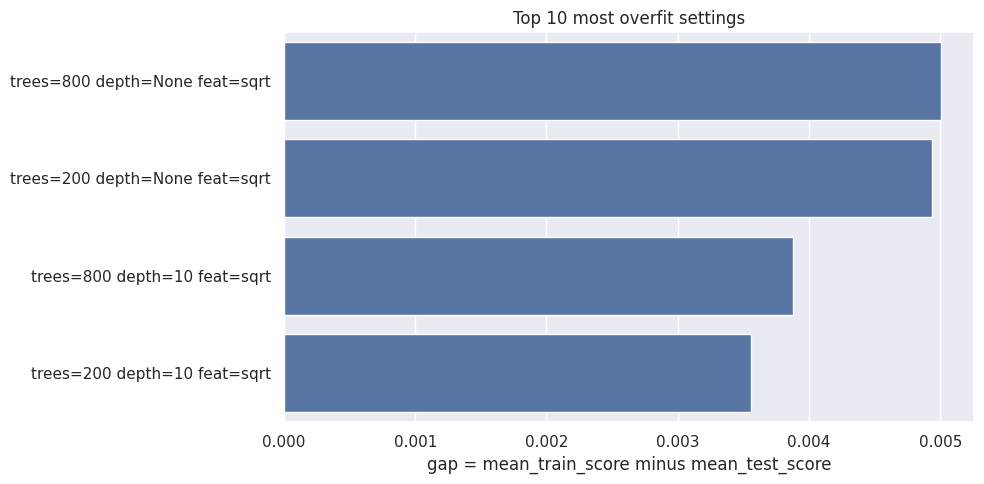

,mean_train_score,mean_test_score,param_bootstrap,param_max_depth,param_max_features,param_n_estimators,gap,setting
1,1.000000,0.994994,True,None,sqrt,800,0.005006,trees=800 depth=None feat=sqrt
0,1.000000,0.995060,True,None,sqrt,200,0.004940,trees=200 depth=None feat=sqrt
3,0.998061,0.994185,True,10,sqrt,800,0.003877,trees=800 depth=10 feat=sqrt
2,0.998065,0.994506,True,10,sqrt,200,0.003558,trees=200 depth=10 feat=sqrt


In [37]:
res_df = gridsearch_overfit_bar(gridSearch, top_k=10)
res_df.sort_values("gap", ascending=False).head(10)


Interpretation:

1) This is performing WAY better than I would expect and it is likely I have done something wrong. I do not have time to figure out what could be wrong.

2) With the caveates something is may be wrong and that the differences are not statistically significant, the top overfit settings based on the delta between the train and test set does fit my expectations.

For example, I would expect a much higher tree depth to result in a larger gap between train and test sets which we do see.

Test accuracy: 0.9975777149777957
                precision    recall  f1-score   support

Adipose Tissue       0.99      0.99      0.99       241
         Blood       1.00      1.00      1.00       186
  Blood Vessel       0.99      0.99      0.99       267
         Brain       1.00      1.00      1.00       528
         Colon       1.00      0.99      1.00       156
     Esophagus       1.00      1.00      1.00       289
         Heart       1.00      1.00      1.00       172
          Lung       1.00      1.00      1.00       116
        Muscle       1.00      1.00      1.00       160
          Skin       1.00      1.00      1.00       362

      accuracy                           1.00      2477
     macro avg       1.00      1.00      1.00      2477
  weighted avg       1.00      1.00      1.00      2477



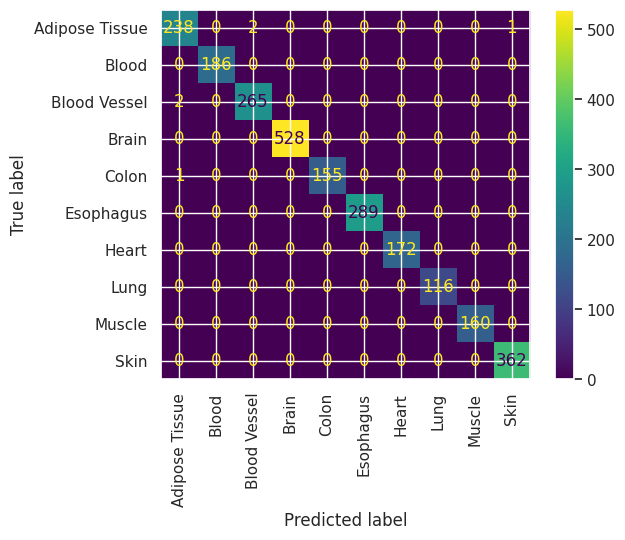

In [ ]:

best_model = gridSearch.best_estimator_

test_acc = best_model.score(X_test, y_test)
print("Test accuracy:", test_acc)

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(xticks_rotation=90)

In [ ]:
dummy = DummyClassifier(strategy="stratified", random_state=42) #Using stratified to predict the most frequent class
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)
print("Test accuracy:", dummy.score(X_test, y_test))
print(classification_report(y_test, y_pred, zero_division=0))

Test accuracy: 0.12111425111021397
                precision    recall  f1-score   support

Adipose Tissue       0.09      0.08      0.08       241
         Blood       0.09      0.09      0.09       186
  Blood Vessel       0.08      0.07      0.08       267
         Brain       0.20      0.21      0.21       528
         Colon       0.07      0.08      0.08       156
     Esophagus       0.12      0.11      0.11       289
         Heart       0.06      0.06      0.06       172
          Lung       0.08      0.07      0.07       116
        Muscle       0.05      0.04      0.04       160
          Skin       0.16      0.17      0.17       362

      accuracy                           0.12      2477
     macro avg       0.10      0.10      0.10      2477
  weighted avg       0.12      0.12      0.12      2477



Interpretation:

The random forest model performs nearly perfect on the held out test data on the best classifier. I am less suspicious I did something wrong now, but there may be something I messed up with data preprocessing. I ensured the tissue column was not in the train set. 

Tissue classification should be relatively easy task, but was not expecting it to be this good. 

The dummy classfier above I am using as a control performs horribly as expected.

### Use AdaBoost on decision tree stump

Create weaker classifier

In [42]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
stump = DecisionTreeClassifier(max_depth=1, random_state=42)
ada = AdaBoostClassifier(estimator=stump,random_state=42)
param_grid_ada = {"n_estimators": [3, 50],"learning_rate": [0.1, 0.3]}
adaSearch = GridSearchCV(estimator=ada,param_grid=param_grid_ada,scoring="f1_macro",cv=cv,n_jobs=104,return_train_score=True,verbose=3)
adaSearch.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[CV 5/5] END learning_rate=0.1, n_estimators=3;, score=(train=0.131, test=0.131) total time=  14.5s
[CV 1/5] END learning_rate=0.1, n_estimators=3;, score=(train=0.131, test=0.131) total time=  14.5s
[CV 1/5] END learning_rate=0.3, n_estimators=3;, score=(train=0.131, test=0.131) total time=  14.5s
[CV 4/5] END learning_rate=0.3, n_estimators=3;, score=(train=0.131, test=0.131) total time=  14.5s
[CV 3/5] END learning_rate=0.3, n_estimators=3;, score=(train=0.131, test=0.131) total time=  14.5s
[CV 5/5] END learning_rate=0.3, n_estimators=3;, score=(train=0.131, test=0.131) total time=  14.5s
[CV 2/5] END learning_rate=0.1, n_estimators=3;, score=(train=0.131, test=0.131) total time=  14.6s
[CV 4/5] END learning_rate=0.1, n_estimators=3;, score=(train=0.131, test=0.131) total time=  14.7s
[CV 2/5] END learning_rate=0.3, n_estimators=3;, score=(train=0.131, test=0.131) total time=  14.8s
[CV 3/5] END learning_rate=0.1, n_estimators=3;, score=(train=0.131, test=0.131) total time=  14.8s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                                           random_state=42),
                                          random_state=42),
             n_jobs=104,
             param_grid={'learning_rate': [0.1, 0.3], 'n_estimators': [3, 50]},
             return_train_score=True, scoring='f1_macro', verbose=3)

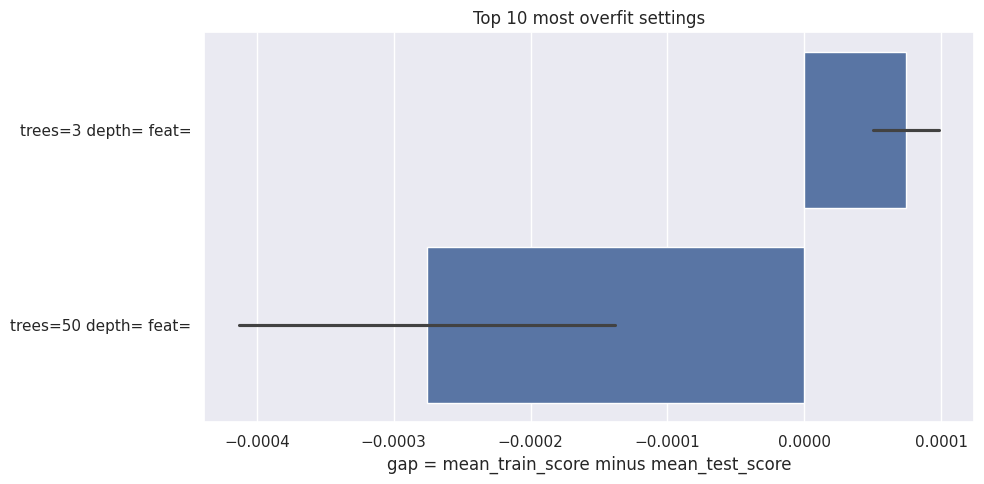

,mean_train_score,mean_test_score,param_learning_rate,param_n_estimators,gap,setting
2,0.131286,0.131187,0.3,3,0.000098,trees=3 depth= feat=
0,0.131265,0.131214,0.1,3,0.000050,trees=3 depth= feat=
1,0.140108,0.140246,0.1,50,-0.000138,trees=50 depth= feat=
3,0.133698,0.134110,0.3,50,-0.000413,trees=50 depth= feat=


In [43]:
res_df = gridsearch_overfit_bar(adaSearch, top_k=10)
res_df.sort_values("gap", ascending=False).head(10)

Test accuracy: 0.3593056116269681
                precision    recall  f1-score   support

Adipose Tissue       0.00      0.00      0.00       241
         Blood       0.00      0.00      0.00       186
  Blood Vessel       0.00      0.00      0.00       267
         Brain       1.00      1.00      1.00       528
         Colon       0.00      0.00      0.00       156
     Esophagus       0.00      0.00      0.00       289
         Heart       0.00      0.00      0.00       172
          Lung       0.00      0.00      0.00       116
        Muscle       0.00      0.00      0.00       160
          Skin       0.27      1.00      0.43       362

      accuracy                           0.36      2477
     macro avg       0.13      0.20      0.14      2477
  weighted avg       0.25      0.36      0.28      2477



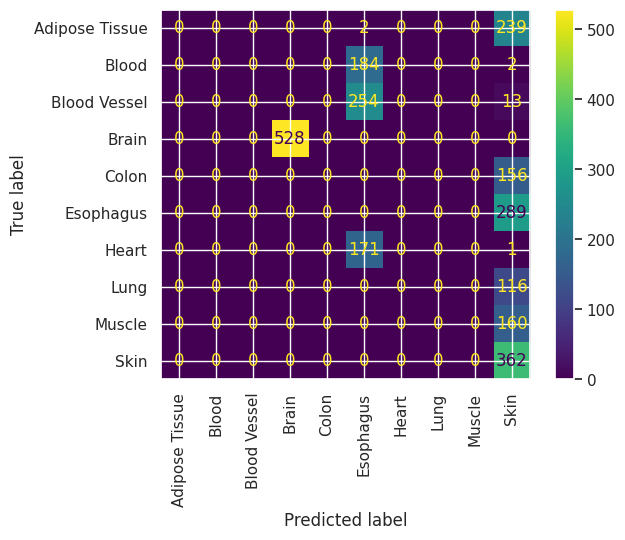

In [44]:

best_model = adaSearch.best_estimator_

test_acc = best_model.score(X_test, y_test)
print("Test accuracy:", test_acc)

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(xticks_rotation=90)

Interpretation:

Training the weak adaboost model resulted in extremely poor performance as we would expect. It performs over twice as well as the dummy decision model (0.28 vs. 0.12 f1-score). 